In [1]:
# download the metadata for all images, 50000 train images, 50000 test images
from huggingface_hub import snapshot_download
snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=[
    'images/train/00.zip',
    'images/train/01.zip',
    'images/test/00.zip',
    'images/test/01.zip',
    '*.csv'
    ], repo_type='dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

01.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/116M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

01.zip:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

'/content/datasets/osv5m'

In [2]:
import os
import zipfile
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                zip_ref.extractall(root)
                os.remove(os.path.join(root, file))

In [3]:
import torch
import numpy as np
import pandas as pd
import csv
# Haversine distance - length of an arc between two points on a sphere
# https://github.com/gastruc/osv5m/blob/main/metrics/utils.py
def haversine(pred, gt):
    # expects inputs to be np arrays in (lat, lon) format as radians
    # N x 2

    # calculate the difference in latitude and longitude between the predicted and ground truth points
    lat_diff = pred[:, 0] - gt[:, 0]
    lon_diff = pred[:, 1] - gt[:, 1]

    # calculate the haversine formula components
    lhs = torch.sin(lat_diff / 2) ** 2
    rhs = torch.cos(pred[:, 0]) * torch.cos(gt[:, 0]) * torch.sin(lon_diff / 2) ** 2
    a = lhs + rhs

    # calculate the final distance using the haversine formula
    c = 2 * torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = 6371 * c

    return distance
davis = np.array([[43.547504,-79.662211]])
glasgow = np.array([[55.853467, -4.249420]])

davis_tensor = torch.tensor(davis, dtype=torch.float32).deg2rad()
glasgow_tensor = torch.tensor(glasgow, dtype=torch.float32).deg2rad()

haversine(davis_tensor, glasgow_tensor)

tensor([5307.1450])

In [4]:
def predict_utm(image_id) -> list[float]:
  # returns the predicted latitude and longitude of a given image
  return [43.547504,-79.662211]

In [5]:
# https://github.com/gastruc/osv5m/blob/main/metrics/distance_based.py
def geoscore(distance):
  return 5000 * torch.exp(-distance / 1492.7)

In [6]:
file = open('datasets/osv5m/test.csv', mode='r', newline='', encoding='utf-8')
reader = csv.reader(file)

test_gt = {}
for row in reader:
  if row[0] == 'id':
    continue
  test_gt[int(row[0])] = np.array([float(row[1]), float(row[2])])

file.close()
print(test_gt[1000055667540054])

[60.77272916 -0.83074192]


In [7]:
# evaluate a predictor by its average geoscore on the first n images from the test set

def evaluate(predictor, n):
  test_path = '/content/datasets/osv5m/images/test/00'
  i = 0
  geoscore_value = 0
  for image_id in os.listdir(test_path):
    id = int(image_id[:image_id.index('.')])
    prediction = np.array(predictor(id))
    gt = test_gt[id]

    prediction_torch = torch.tensor(prediction.reshape(1,2), dtype=torch.float32).deg2rad()
    test_gt_torch = torch.tensor(gt.reshape(1,2), dtype=torch.float32).deg2rad()

    distance = haversine(prediction_torch, test_gt_torch)
    geoscore_value += geoscore(distance)
    i += 1
    if i == n:
      break
  return geoscore_value / n

print("avg geoscore: ",evaluate(predict_utm, 10000).item())

avg geoscore:  332.96466064453125


In [8]:
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

from tqdm.notebook import trange, tqdm
from time import sleep
import csv
import numpy as np

In [9]:
!pip install global_land_mask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.7 MB/s eta 0:00:00


In [29]:
# Blocks below contain some code generated with deepseek R1 with the following prompt:
# "write a pytorch model in jupyter format to classify outdoor images by their latitude and longitude"

# Step 2: Define the custom dataset

# MAX_FILES = 100000
from global_land_mask import globe
import os.path
from pathlib import Path

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dirs, train: bool, transform=None):
        self.data = []
        self.skipped = []
        self.files = []
        for image_dir in image_dirs:
          self.files.extend([f"{image_dir}/{f}" for f in listdir(image_dir) if isfile(join(image_dir, f))])
        self.csv = 'datasets/osv5m/train.csv' if train else 'datasets/osv5m/test.csv'

        print('Reading', self.csv)
        df = pd.read_csv(self.csv, usecols=range(3))
        row_count, column_count = df.shape
        print('Filtering files...')
        print(self.files[:5])
        print(df[:5])
        for full_path in tqdm(self.files, total=len(self.files), desc='Processing files'):
            image_name = str(Path(full_path).stem)

            row = df[df['id'] == int(image_name)].iloc[0]

            lat = row['latitude']
            lon = row['longitude']

            # Remove mislaballed images (ocean pictures?)
            if not globe.is_land(float(lat), float(lon)):
              self.skipped.append(image_name)
              continue
            self.data.append(np.array([str(full_path), float(lat), float(lon)]))

        self.transform = transform
        print(f'Dataset ready, {len(self.data)} files.')
        print(f'Skipped {len(self.skipped)} non-land files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx][0]
        image = Image.open(img_path).convert('RGB')
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coordinates, dtype=torch.float32)


In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=['/content/datasets/osv5m/images/train/00',
                                             '/content/datasets/osv5m/images/train/01'],\
                                 train=True,
                                 transform=transform)
# print(dataset[0])

Reading datasets/osv5m/train.csv
Filtering files...
['/content/datasets/osv5m/images/train/00/674519266662437.jpg', '/content/datasets/osv5m/images/train/00/319612372849941.jpg', '/content/datasets/osv5m/images/train/00/972383180172318.jpg', '/content/datasets/osv5m/images/train/00/134357192070832.jpg', '/content/datasets/osv5m/images/train/00/375071537190479.jpg']
                 id   latitude   longitude
0  3859149887465501 -43.804769 -176.614093
1   574181207305439 -43.796611 -176.660483
2   333574322129026 -43.818092 -176.578383
3   636305258168031 -44.052910 -176.633065
4   166741299029322 -43.748077 -176.329626


Processing files:   0%|          | 0/100000 [00:00<?, ?it/s]

Dataset ready, 98982 files.
Skipped 1018 non-land files.


In [32]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [33]:
# Step 5: Define the model
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

import torchvision.models as models

class GeoLocationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(GeoLocationModel, self).__init__()
        # Use a pre-trained ResNet-18 model as the backbone
        self.backbone = models.resnet18(pretrained=pretrained)

        # Replace the final fully connected layer to output 2 values (latitude and longitude)
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.backbone(x)

model = GeoLocationModel().to(device)
# print(model)

using cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Step 6: Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Step 7: Train the model
num_epochs = 5
avg_epoch_loss = []
for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
  train_loss = []
  avg_loss = 0
  for images, coordinates in tqdm(dataloader, total=len(dataloader), desc=f'Epoch {epoch + 1} progress'):
    # Forward pass
    images, coordinates = images.cuda(), coordinates.cuda()
    outputs = model(images)
    loss = criterion(outputs, coordinates)
    train_loss.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  avg_loss = sum(train_loss) / len(dataloader)
  avg_epoch_loss.append(avg_loss)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 progress:   0%|          | 0/1547 [00:00<?, ?it/s]

Epoch [1/5], Loss: 369021.5285


Epoch 2 progress:   0%|          | 0/1547 [00:00<?, ?it/s]

Epoch [2/5], Loss: 33812.5229


Epoch 3 progress:   0%|          | 0/1547 [00:00<?, ?it/s]

Epoch [3/5], Loss: 7623.6760


Epoch 4 progress:   0%|          | 0/1547 [00:00<?, ?it/s]

Epoch [4/5], Loss: 5140.4847


Epoch 5 progress:   0%|          | 0/1547 [00:00<?, ?it/s]

Epoch [5/5], Loss: 4345.6248


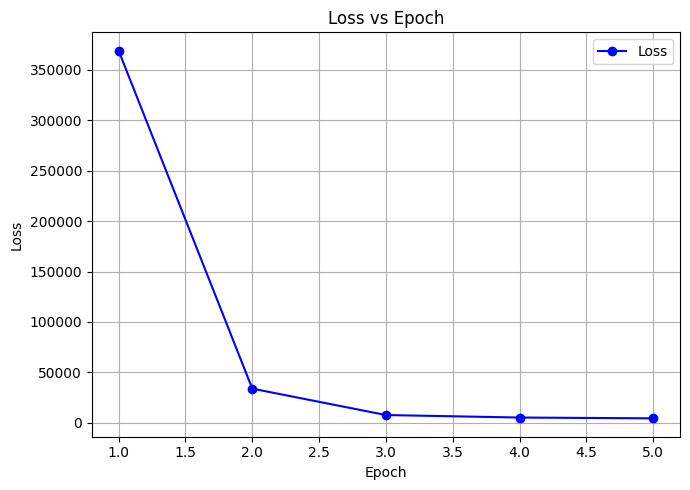

In [38]:

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', \
                                 image_dirs=['/content/datasets/osv5m/images/test/00', \
                                             '/content/datasets/osv5m/images/test/01'], \
                                     train=False,
                                 transform=transform)
val_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Reading datasets/osv5m/test.csv
Filtering files...
['/content/datasets/osv5m/images/test/00/490453918897800.jpg', '/content/datasets/osv5m/images/test/00/466522557966153.jpg', '/content/datasets/osv5m/images/test/00/451539402809844.jpg', '/content/datasets/osv5m/images/test/00/232844248635122.jpg', '/content/datasets/osv5m/images/test/00/146762707404386.jpg']
                 id   latitude  longitude
0   547473234108938 -16.336027  45.628280
1   826109781317024  50.855687  56.147997
2  1006398440000844  37.956651  14.954485
3  2943891539215481  12.373333  -8.909906
4   122945119799579   7.510295  99.061884


Processing files:   0%|          | 0/100000 [00:00<?, ?it/s]

Dataset ready, 98621 files.
Skipped 1379 non-land files.


In [40]:
# Model: deepseek r1
# Prompt: now write code to validate this
model.eval()  # Set the model to evaluation mode

GeoLocationModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [41]:
# Step 4: Validate the model
val_loss = 0.0
val_mae = 0.0
criterion = nn.MSELoss()  # Use MSE for loss calculation
mae_criterion = nn.L1Loss()  # Use MAE for error calculation

In [42]:
batch_val_losses = []
batch_val_mae = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates in tqdm(val_dataloader, total=len(dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, coordinates)
        val_loss += loss.item()

        # Calculate MAE
        mae = mae_criterion(outputs, coordinates)
        val_mae += mae.item()

        # Store batch-wise loss and MAE
        batch_val_losses.append(loss.item())
        batch_val_mae.append(mae.item())

# Calculate average loss and MAE
val_loss /= len(val_dataloader)
val_mae /= len(val_dataloader)

print(f'Validation Loss (MSE): {val_loss:.4f}')
print(f'Validation MAE: {val_mae:.4f}')

Validating:   0%|          | 0/1547 [00:00<?, ?it/s]

Validation Loss (MSE): 2730.6389
Validation MAE: 38.3780


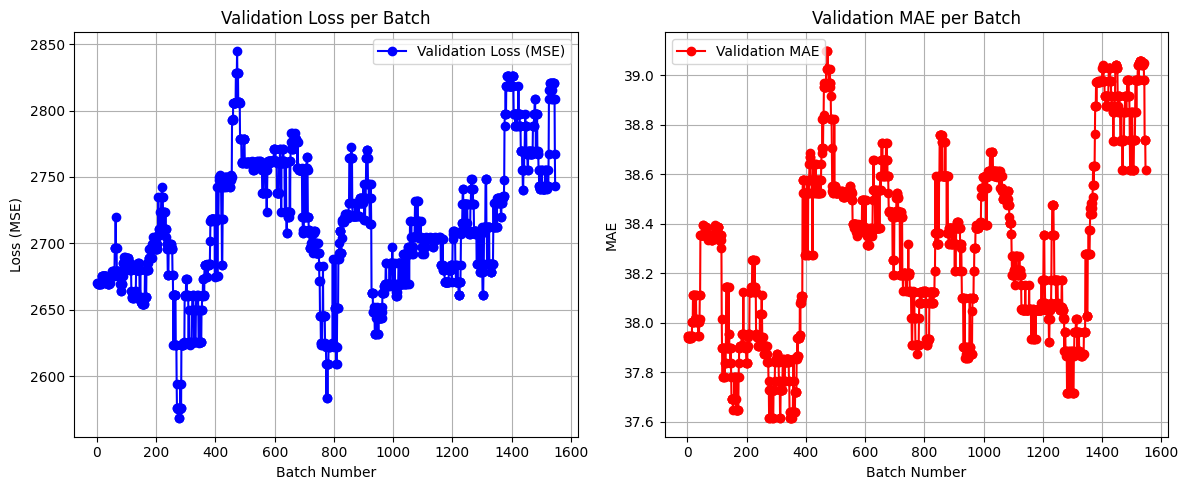

In [43]:
# Model: deepseek r1
# Prompt: write matplotlib code to plot previous validation loop:

import matplotlib.pyplot as plt

# Remove outliers
from scipy.ndimage import median_filter

batch_val_losses = median_filter(batch_val_losses, size=100)
batch_val_mae = median_filter(batch_val_mae, size=100)

# Step 1: Plot Validation Loss per Batch
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(batch_val_losses) + 1), batch_val_losses, label='Validation Loss (MSE)', color='blue', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss per Batch')
plt.legend()
plt.grid(True)

# Step 2: Plot Validation MAE per Batch
plt.subplot(1, 2, 2)
plt.plot(range(1, len(batch_val_mae) + 1), batch_val_mae, label='Validation MAE', color='red', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('MAE')
plt.title('Validation MAE per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [45]:
# Step 5: Visualize some predictions (optional)
import matplotlib.pyplot as plt
import random

def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, coordinates in dataloader:
            images = images.cuda()
            outputs = model(images)
            images = images.cpu()
            outputs = outputs.cpu()
            rand_index = random.sample(range(0, len(images) - 1), min(num_samples, len(images)))
            for i in range(min(num_samples, len(images))):
                i = rand_index[i]

                pred_lon, pred_lat = outputs[i].cpu().numpy()
                true_lon, true_lat = coordinates[i].numpy()

                haver_err = haversine(
                                      torch.tensor(np.array([[pred_lon, pred_lat]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lon, true_lat]]), dtype=torch.float32).deg2rad(),
                                      )

                print(f'Sample {i+1}:')
                print(f'  Predicted: Latitude = {pred_lat:.4f}, Longitude = {pred_lon:.4f}')
                print(f'  True:      Latitude = {true_lat:.4f}, Longitude = {true_lon:.4f}')
                print(f'haversine: {haver_err}')

                # Display the image
                img = images[i].permute(1, 2, 0).numpy()
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Reverse normalization
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lat, pred_lon), Point(true_lat, true_lon)]
                geo_df = GeoDataFrame(geometry = geometry)
                url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

Sample 5:
  Predicted: Latitude = -5.1215, Longitude = 27.9844
  True:      Latitude = 36.3023, Longitude = 40.7552
haversine: tensor([4014.9041])


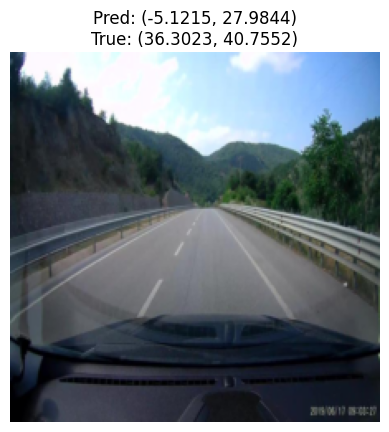

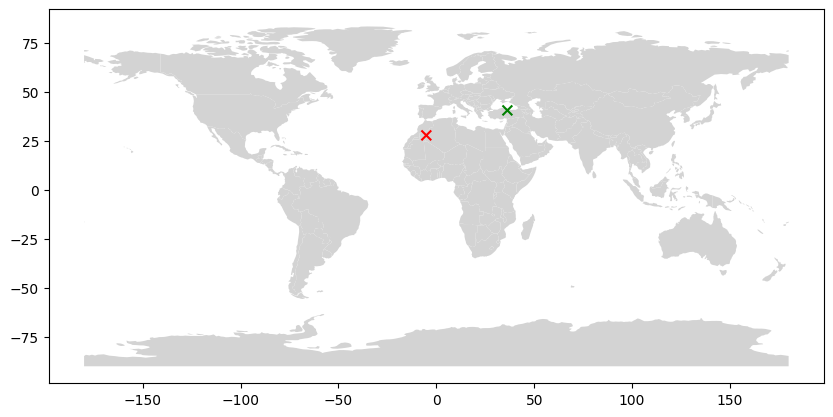

Sample 16:
  Predicted: Latitude = -65.8130, Longitude = 17.7461
  True:      Latitude = -109.0068, Longitude = 38.9604
haversine: tensor([4779.3779])


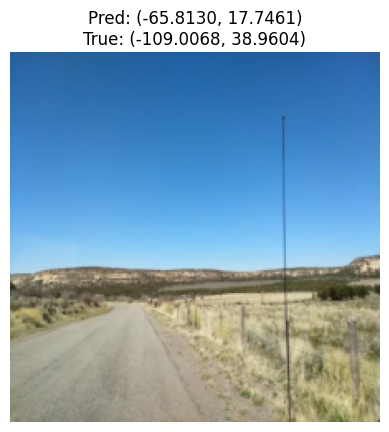

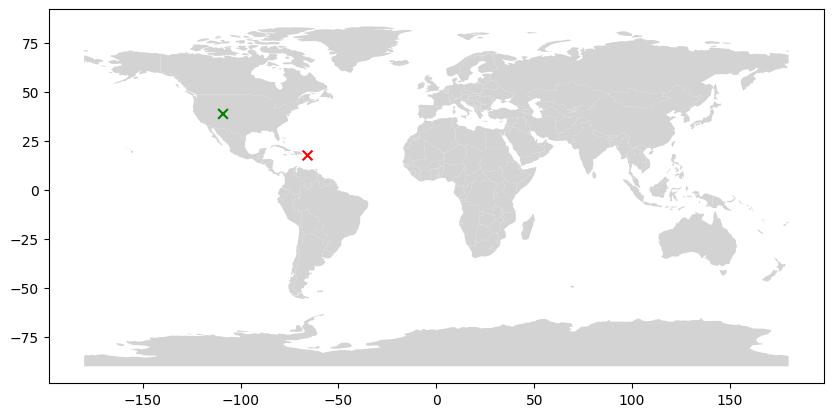

Sample 24:
  Predicted: Latitude = -27.6878, Longitude = 26.0352
  True:      Latitude = 10.1008, Longitude = 49.7680
haversine: tensor([4165.9614])


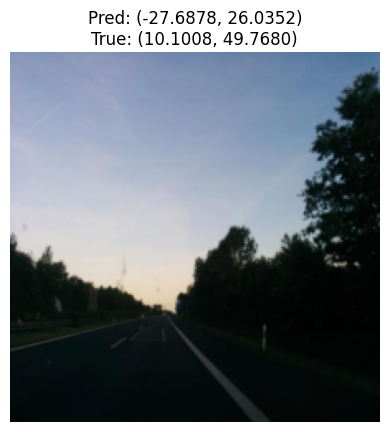

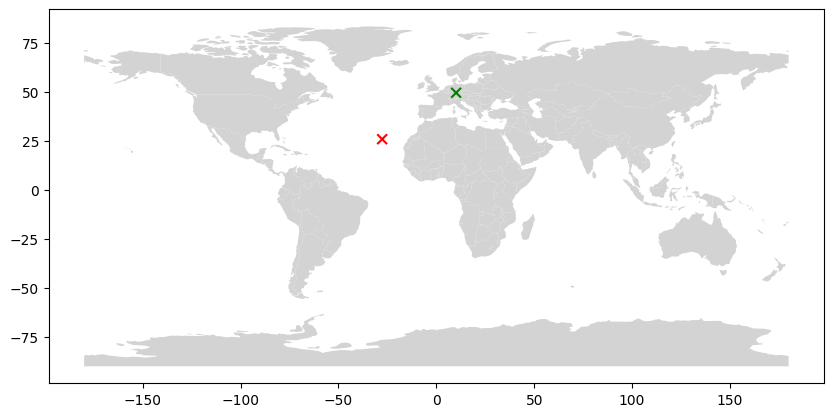

Sample 58:
  Predicted: Latitude = -19.6005, Longitude = 26.4882
  True:      Latitude = 50.1953, Longitude = 53.2192
haversine: tensor([6355.7998])


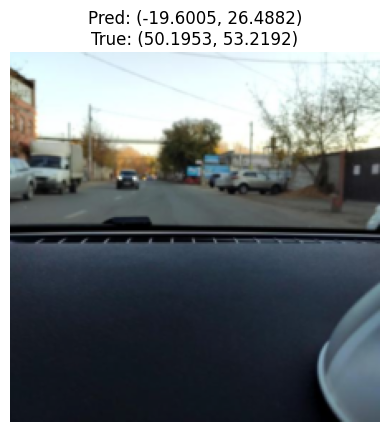

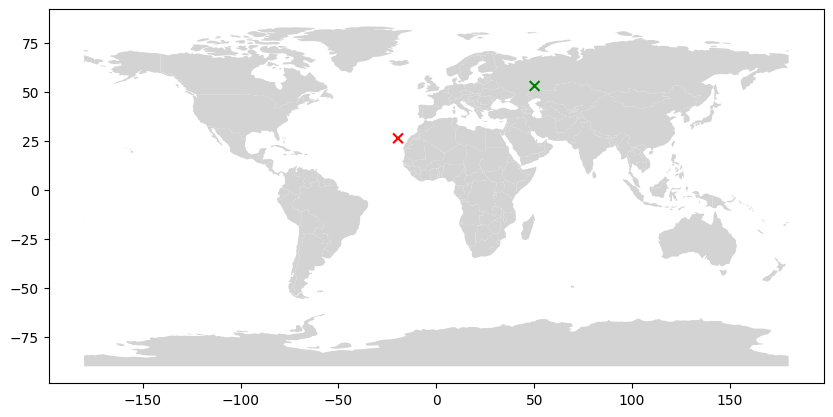

Sample 4:
  Predicted: Latitude = -48.9602, Longitude = 20.2131
  True:      Latitude = 30.5071, Longitude = -29.7336
haversine: tensor([10150.3174])


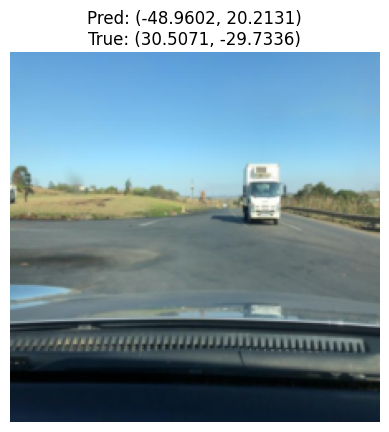

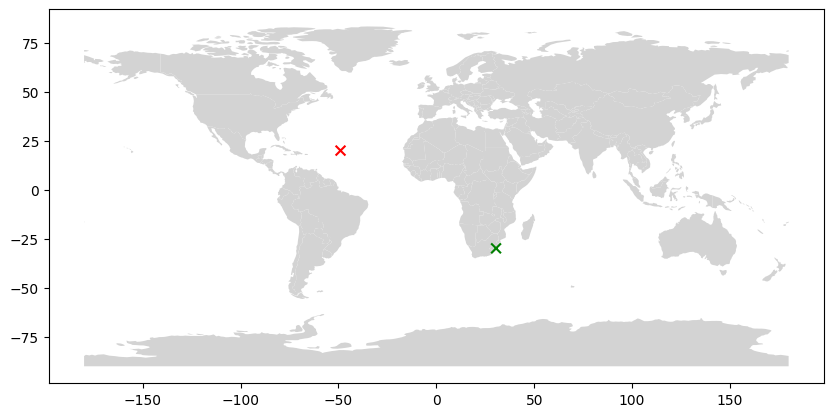

Sample 3:
  Predicted: Latitude = 23.4775, Longitude = 12.8712
  True:      Latitude = -8.8808, Longitude = 38.8053
haversine: tensor([4294.0762])


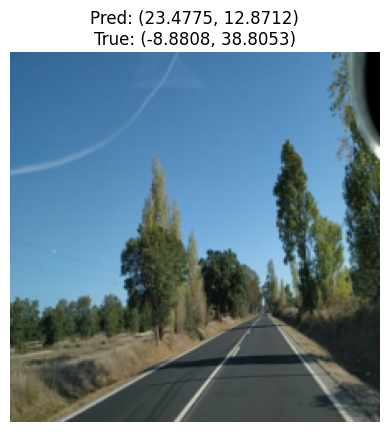

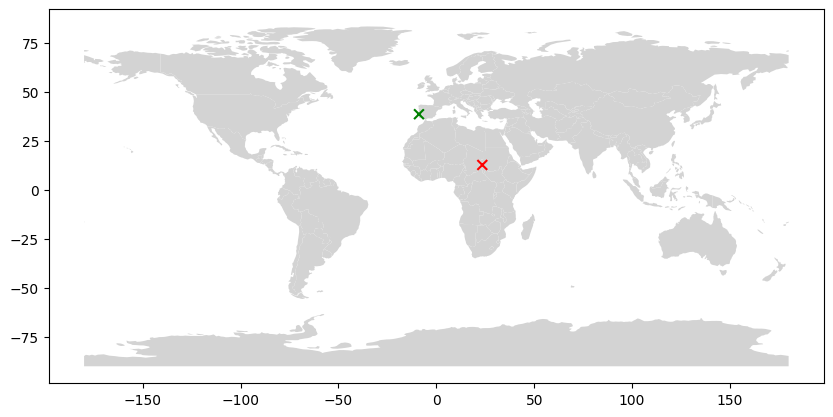

Sample 59:
  Predicted: Latitude = -18.2774, Longitude = 20.0790
  True:      Latitude = -46.1901, Longitude = -23.3959
haversine: tensor([5703.0708])


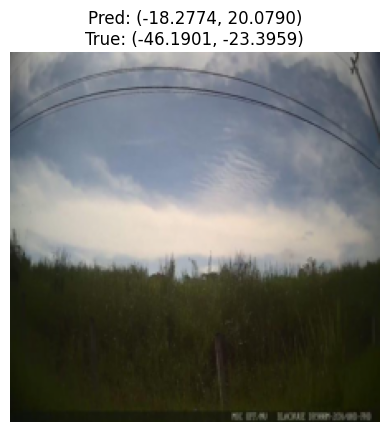

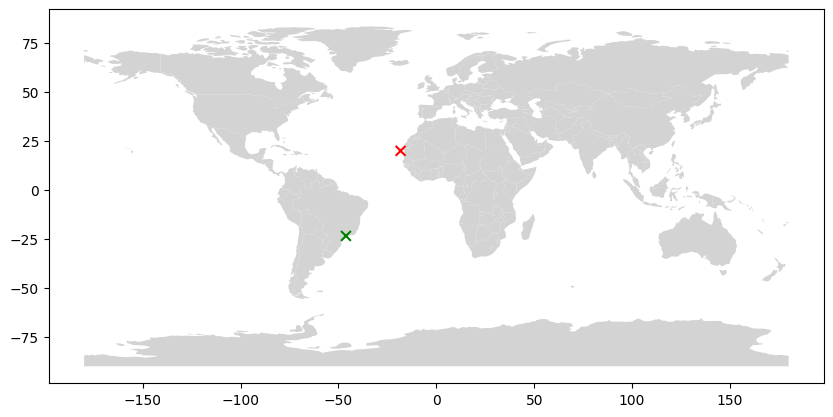

Sample 62:
  Predicted: Latitude = 26.5785, Longitude = 10.4690
  True:      Latitude = 147.6420, Longitude = -42.6166
haversine: tensor([13317.1211])


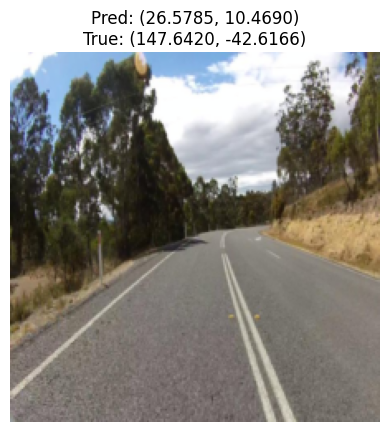

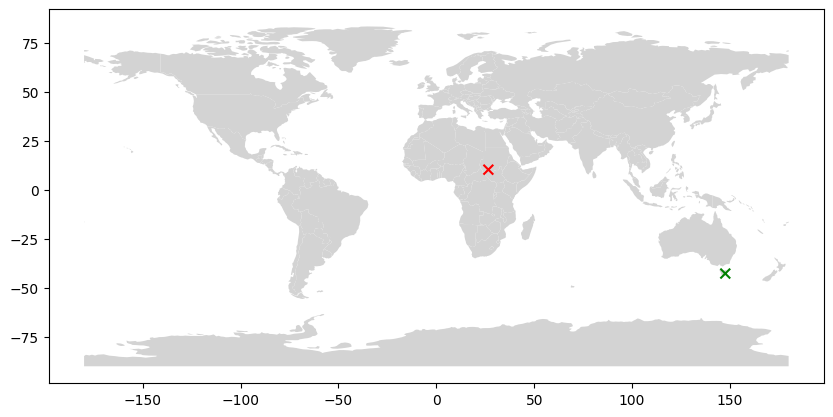

Sample 6:
  Predicted: Latitude = -12.6310, Longitude = 38.7667
  True:      Latitude = -98.6352, Longitude = 29.6556
haversine: tensor([7681.6045])


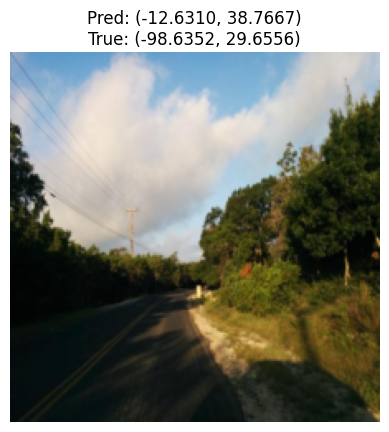

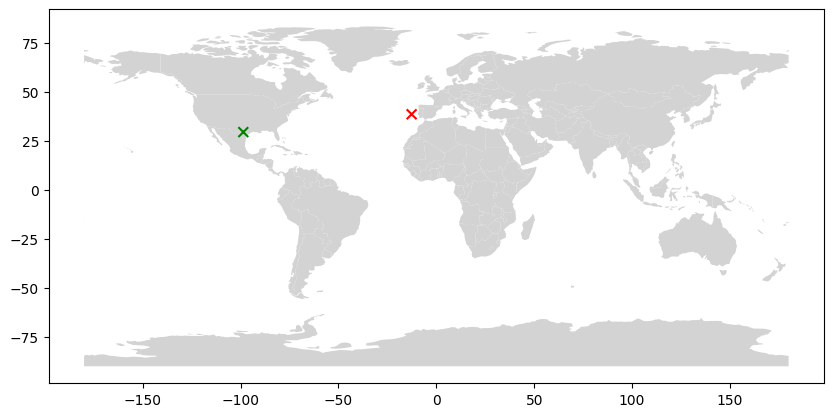

Sample 37:
  Predicted: Latitude = -59.7613, Longitude = 19.9249
  True:      Latitude = -111.2849, Longitude = 36.7511
haversine: tensor([5307.6084])


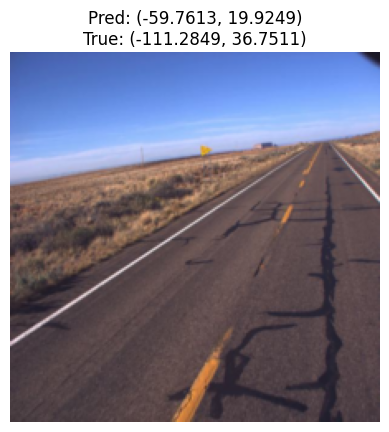

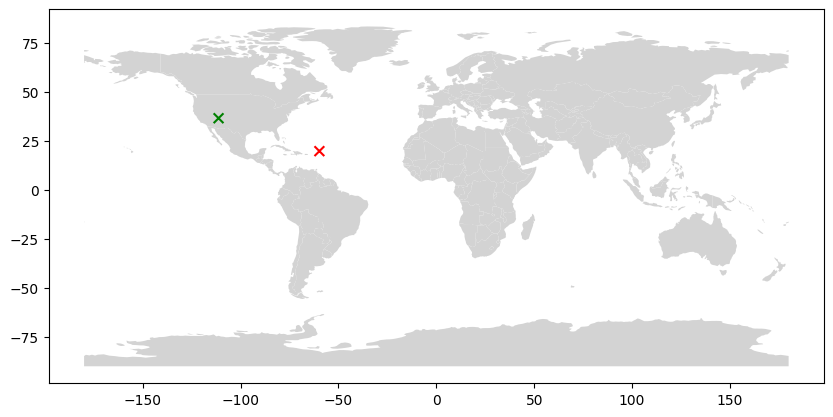

In [46]:
# Plot some predictions
plot_predictions(model, val_dataloader, num_samples=10)